In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os, cv2
import tensorflow as tf
import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
def shuffle(a, b=None):
    p = np.random.permutation(len(a))
    if b is None:
        return a[p]
    return a[p], b[p]

<h1>Model</h1>

In [3]:
"""
NVIDIA model used
Image normalization to avoid saturation and make gradients work better.
Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
Drop out (0.5)
Fully connected: neurons: 100, activation: ELU
Fully connected: neurons: 50, activation: ELU
Fully connected: neurons: 10, activation: ELU
Fully connected: neurons: 1 (output)
# the convolution layers are meant to handle feature engineering
the fully connected layer for predicting the steering angle.
dropout avoids overfitting
ELU(Exponential linear unit) function takes care of the Vanishing gradient problem. 
"""

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME') # convolution with every step = 1. strides=[N,H,W,C]

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') # pooling

x = tf.placeholder(tf.float32, [None, 150, 400, 3])
y_ = tf.placeholder(tf.float32, [None, 2])

W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

W_fc1 = weight_variable([19 * 50 * 64, 100])
b_fc1 = bias_variable([100])

W_fc2 = weight_variable([100, 50])
b_fc2 = bias_variable([50])

W_fc3 = weight_variable([50, 16])
b_fc3 = bias_variable([16])

W_fc4 = weight_variable([16, 2])
b_fc4 = bias_variable([2])

h_conv1 = tf.nn.elu(conv2d(x, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

h_conv2 = tf.nn.elu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

h_conv3 = tf.nn.elu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

h_conv4 = tf.nn.elu(conv2d(h_pool3, W_conv4) + b_conv4)

h_conv5 = tf.nn.elu(conv2d(h_conv4, W_conv5) + b_conv5)

h_pool5_flat = tf.reshape(h_conv5, [-1, 19 * 50 * 64])
h_fc1 = tf.nn.elu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1)

h_fc2 = tf.nn.elu(tf.matmul(h_fc1, W_fc2) + b_fc2)

h_fc3 = tf.nn.elu(tf.matmul(h_fc2, W_fc3) + b_fc3)

y_pred = tf.nn.tanh(tf.matmul(h_fc3, W_fc4) + b_fc4)

loss = tf.reduce_mean(tf.losses.mean_squared_error(y_, y_pred))

train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

#correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()

saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(init)

# with tf.device('/gpu:0'):
#     net = input_data(shape=[None, 160, 320, 3], name='input')
#     net = conv_2d(net, 24, 5, strides=1, activation='relu')
#     net = max_pool_2d(net, 2, strides=2)
#     net = conv_2d(net, 36, 5, strides=1, activation='relu')
#     net = max_pool_2d(net, 2, strides=2)
#     net = conv_2d(net, 48, 5, strides=1, activation='relu')
#     net = max_pool_2d(net, 2, strides=2)
#     net = conv_2d(net, 64, 3, strides=1, activation='relu')
#     net = conv_2d(net, 64, 3, strides=1, activation='relu')
#     net = fully_connected(net, 100, activation='relu')
#     net = fully_connected(net, 50, activation='relu')
#     net = fully_connected(net, 10, activation='relu')
#     net = fully_connected(net, 2, activation='relu')
    
#     net = regression(net, optimizer='adam',
#                              loss=tflearn.objectives.mean_square,#'categorical_crossentropy', #tflearn.objectives.mean_square (y_pred, y_true)
#                              learning_rate=1e-4, name='targets')
    
#     model = tflearn.DNN(net, checkpoint_path='model1',
#                         max_checkpoints=1, tensorboard_verbose=2, tensorboard_dir='log')

INFO:tensorflow:Restoring parameters from back1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
Old max loss: 23.93234634399414 new: 2.845012903213501
Training set size: 25487. Test set size: 6372


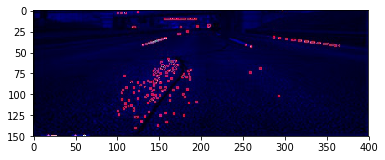

In [7]:
DATA_PATH = '../../data/sdnfsmw'

X = np.array([])
y = np.zeros(shape=(0,2))

def append_run_data(X, y, run_name, entries):
    for i in range(entries):
        filename = 'run_{}_info.csv'.format(i)
        data_df = pd.read_csv(os.path.join(os.getcwd(),
                                           DATA_PATH,
                                           run_name,
                                           filename),
                              names=['image', 'LSX', 'T'], header=0)
        tX = data_df['image'].values
        ty = data_df[['LSX', 'T']].values
        #print(y.shape)
        X = np.concatenate((X, tX), axis=0)
        y = np.concatenate((y, ty), axis=0)
    return X, y

def normalize(X, y):
    newX = np.array([])
    newY = np.zeros(shape=(0,2))
    straightX = np.array([])
    straightY = np.zeros(shape=(0,2))
    turnX = np.array([])
    turnY = np.zeros(shape=(0,2))
    for i, e in enumerate(y):
        if np.abs(e[0]) > 0.3:
            turnX = np.concatenate((turnX, [X[i]]), axis=0)
            turnY = np.concatenate((turnY, [y[i]]), axis=0)
        else:
            straightX = np.concatenate((straightX, [X[i]]), axis=0)
            straightY = np.concatenate((straightY, [y[i]]), axis=0)
    min_len = min(len(straightX), len(turnX))
    newX = np.concatenate((straightX[:min_len], turnX[:min_len]), axis=0)
    newY = np.concatenate((straightY[:min_len], turnY[:min_len]), axis=0)
    return newX, newY

def prepare_image(X):
    bs = len(X)
    Xs = np.empty([bs, 150, 400, 3])
    for i in range(bs):
        path = os.path.join(os.getcwd(), DATA_PATH, X_train[i])
        img = mpimg.imread(path) / 256.
        steering, throttle = y_train[i]
        Xs[i] = img
    return Xs

def remove_outliers(X, y, part=0.9):
    global sess, x, y_
    saver.restore(sess, "back1")
    losses = np.array([])
    for i in range(0, len(X)-1, 1):
        if i % 1000 == 0:
            print(i)
        imgs = prepare_image(X[i:i+1])
        feed_dict = {x: imgs, y_: y[i:i+1]}
        losses = np.concatenate((losses, [sess.run(loss, feed_dict=feed_dict)]), axis=0)
    asc_losses = np.argsort(losses)
    print('Old max loss: {} new: {}'.format(losses[asc_losses[-1]], losses[asc_losses[int(len(asc_losses)*part)]]))
    non_outliers = asc_losses[:int(len(asc_losses)*part)]
    return X[non_outliers], y[non_outliers]
        
X, y = append_run_data(X, y, 'data', 40) #>>>>>>>>>>>>>DETECT OUTLIERS<<<<<<<<<<<<<
X, y = append_run_data(X, y, 'data_3', 137) #>>>>>>>>>>>>>>USE NORMALIZATION<<<<<<<<<<<<<

scaler = StandardScaler()
scaler.fit(y)

y = scaler.transform(y)

pkl_file = open('scaler.pkl', 'wb')
pickle.dump(scaler, pkl_file)
pkl_file.close()
# pkl_file = open('scaler.pkl', 'rb')
# scaler = pickle.load(pkl_file)
# pkl_file.close()

X, y = remove_outliers(X, y, 0.8)

X, y = shuffle(X, y)

#X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pkl_file = open('data.pkl', 'wb')
pickle.dump((X_train, X_test, y_train, y_test), pkl_file)
pkl_file.close()

print("Training set size: {}. Test set size: {}".format(len(y_train), len(y_test)))

path = os.path.join(os.getcwd(), DATA_PATH, X_train[20])
img = mpimg.imread(path) / 256.
imgplot = plt.imshow(img)
plt.show()

In [15]:
pkl_file = open('data.pkl', 'rb')
X_train, X_test, y_train, y_test = pickle.load(pkl_file)
pkl_file.close()

# p = np.random.permutation(len(X_train))
# X_train = X_train[p]
# y_train = y_train[p]

current_position = 0
def get_next_batch(bs):
    global current_position
    size = len(X_train)
    Xs = np.empty([bs, 150, 400, 3])
    Ys = np.empty([bs, 2])
    for i in range(bs):
        path = os.path.join(os.getcwd(), DATA_PATH, X_train[(current_position + i) % size])
        img = mpimg.imread(path) / 256.
        steering, throttle = y_train[(current_position + i) % size]
        if np.random.rand() < 0.5:
            img = cv2.flip(img, 1)
            steering = -steering
        Xs[i] = img
        Ys[i] = [steering, throttle]
        
    current_position += bs
    return [Xs, Ys]

current_test_position = 0
def get_next_test_batch(bs):
    global current_test_position
    size = len(X_test)
    Xs = np.empty([bs, 150, 400, 3])
    Ys = np.empty([bs, 2])
    for i in range(bs):
        path = os.path.join(os.getcwd(), DATA_PATH, X_train[(current_test_position + i) % size])
        Xs[i] = mpimg.imread(path) / 256.
        Ys[i] = y_train[(current_test_position + i) % size]
    current_test_position += bs
    return [Xs, Ys]

In [41]:
#saver.restore(sess, "back1")

for i in range(50):
  if i % 1000 == 0:
    X_train, y_train = shuffle(X_train, y_train)
  if i % 50 == 0:
    test_batch = get_next_test_batch(128)
    feed_dict={x: test_batch[0], y_: test_batch[1]}
    print("Epoch: {}, loss: {}".format(i, sess.run(loss, feed_dict=feed_dict)))
  batch = get_next_batch(64)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})

save_path = saver.save(sess, "back1")
print("Model saved in file: %s" % save_path)

test_batch_by_100 = int(len(X_test) / 100)
accs = np.empty([test_batch_by_100])
for i in range(len(accs)):
    test_batch = get_next_test_batch(100)
    feed_dict={x: test_batch[0], y_: test_batch[1]}
    accs[i] = sess.run(loss, feed_dict=feed_dict)
print("Test loss: {}".format(np.average(accs)))

# accs = np.empty([test_batch_by_100])
# for i in range(len(accs)):
#     batch = get_next_batch(100)
#     feed_dict={x: batch[0], y_: batch[1]}
#     accs[i] = sess.run(loss, feed_dict=feed_dict)
# print("Training loss: {}".format(np.average(accs)))

Epoch: 0, loss: 0.014348629862070084
Model saved in file: back1
Test loss: 0.018349645680023563


In [49]:
# img = np.asarray(Image.open(BytesIO(base64.b64decode(last_data["image"])))) / 256.
# img = [img]
# feed_dict={x: img}
# print(sess.run(y_pred, feed_dict=feed_dict)[0])

test_batch = get_next_test_batch(1)
feed_dict={x: test_batch[0]}
print(scaler.inverse_transform(sess.run(y_pred, feed_dict=feed_dict)))
print(scaler.inverse_transform(test_batch[1]))

[[ 0.15510757 -0.32690796]]
[[ 0.12008667 -0.32034302]]


In [23]:
X_train, y_train = remove_outliers(X_train, y_train, 0.9)
X_test, y_test = remove_outliers(X_test, y_test, 0.9)

INFO:tensorflow:Restoring parameters from back1
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
Old max loss: 2.4751977920532227 new: 1.4231834411621094
INFO:tensorflow:Restoring parameters from back1
0
1000
2000
3000
4000
5000
Old max loss: 3.658076524734497 new: 2.067963123321533


In [20]:
len(X_train)

20642